In [32]:
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kb_python.utils import import_matrix_as_anndata
from sklearn.linear_model import LinearRegression
from upsetplot import from_contents, from_indicators
from upsetplot import plot as upset
from scipy.stats import ttest_ind_from_stats
from mx.mx_inspect import mx_inspect_rows, mx_inspect_cols
import muon
import anndata 
fsize = 15
import sys

def nd(arr):
    return np.asarray(arr).reshape(-1)


def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, c="k", alpha=0.75, zorder=0)
    ax.set(**{"aspect": "equal", "xlim": lims, "ylim": lims})
    return ax


plt.rcParams.update({"font.size": fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
blue = "#34CBBF"
red = "#CB3440"

# Read in data

In [3]:
mu = muon.read_h5mu("/home/sina/projects/atac/scATAK/data/10xPBMC/mome_x/kb_peaks_subsam.h5mu")
mg = muon.read_h5mu("/home/sina/projects/atac/scATAK/data/10xPBMC/rna_x/kb_genes_subsam.h5mu")
ma = muon.read_h5mu("/home/sina/projects/atac/scATAK/data/10xPBMC/atac_x/kb_genes_subsam.h5mu")

In [4]:
print(
    mu.mod["gene"].shape,
    mg.mod["gene"].shape,
    mu.mod["atac"].shape,
    ma.mod["atac"].shape,
    sep="\n"
)

(2717033, 60664)
(3183679, 60664)
(646285, 119876)
(435602, 119876)


## Cell counts

In [5]:
rna_lim  = (1_000, 10_000)
atac_lim = (5_000, 15_000)

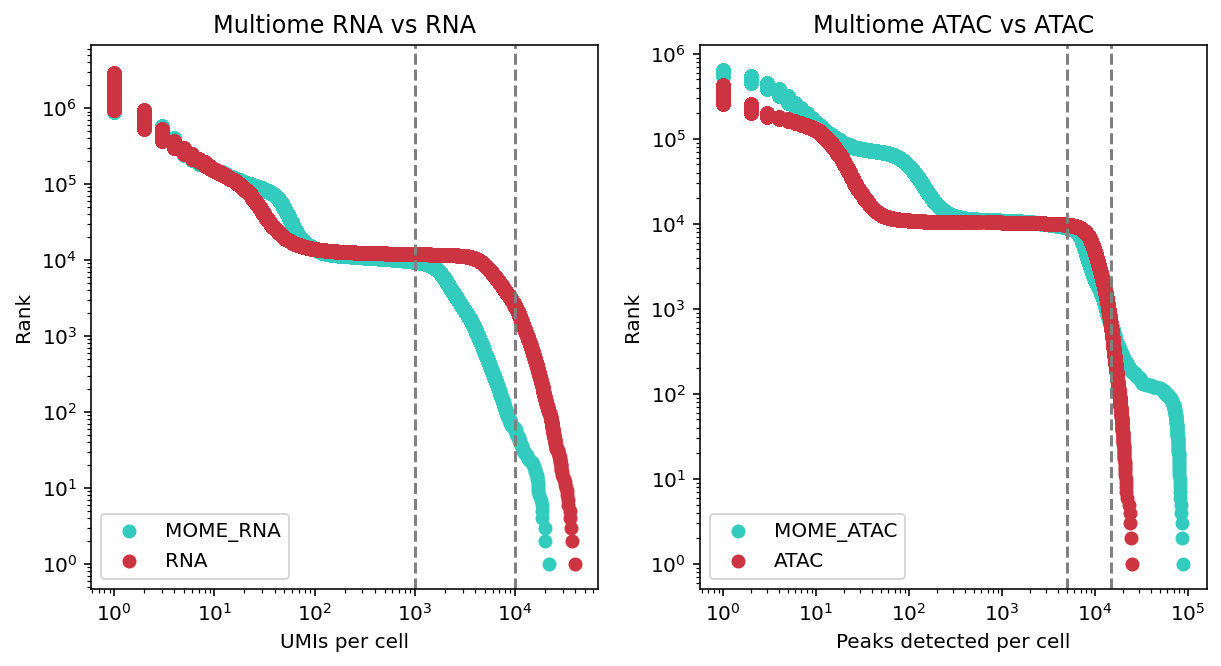

In [6]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax = axs[0]
x = mu.obs["gene:counts_sum"].sort_values(ascending=False)
y = np.arange(x.shape[0])
ax.scatter(x,y, label="MOME_RNA", c=blue)

x = mg.obs["gene:counts_sum"].sort_values(ascending=False)
y = np.arange(x.shape[0])
ax.scatter(x,y, label="RNA", c=red)

ax.set(**{
    "xscale": "log",
    "yscale": "log",
    "xlabel": "UMIs per cell",
    "ylabel": "Rank",
    "title": "Multiome RNA vs RNA"
})
ax.axvline(rna_lim[0], color="grey", linestyle="--")
ax.axvline(rna_lim[1], color="grey", linestyle="--")
ax.legend()

ax = axs[1]
x = mu.obs["atac:counts_nnzero"].sort_values(ascending=False)
y = np.arange(x.shape[0])
ax.scatter(x,y, label="MOME_ATAC", c=blue)

x = ma.obs["atac:counts_nnzero"].sort_values(ascending=False)
y = np.arange(x.shape[0])
ax.scatter(x,y, label="ATAC", c=red)

ax.set(**{
    "xscale": "log",
    "yscale": "log",
    "xlabel": "Peaks detected per cell",
    "ylabel": "Rank",
    "title": "Multiome ATAC vs ATAC"
})
ax.axvline(atac_lim[0], color="grey", linestyle="--")
ax.axvline(atac_lim[1], color="grey", linestyle="--")
ax.legend()
fig.show()

In [8]:
q = f"`gene:counts_sum` > {rna_lim[0]} and `gene:counts_sum` < {rna_lim[1]}"

sum_mu_g = mu.obs.query(q)["gene:counts_sum"].mean()
sum_mg_g = mg.obs.query(q)["gene:counts_sum"].mean()

In [24]:
print(sum_mu_g, sum_mg_g,sum_mu_g/sum_mg_g, sep="\n")

2555.7295
5824.0483
0.43882355


In [10]:
q = f"`atac:counts_nnzero` > {atac_lim[0]} and `atac:counts_nnzero` < {atac_lim[1]}"

sum_mu_a = mu.obs.query(q)["atac:counts_nnzero"].mean()
sum_ma_a = ma.obs.query(q)["atac:counts_nnzero"].mean()

In [25]:
print(sum_mu_a, sum_ma_a,sum_mu_a/sum_ma_a, sep="\n")

8393.733254015468
9833.3067410812
0.8536023003277687


In [27]:
q = f"`gene:counts_sum` > {rna_lim[0]} and `gene:counts_sum` < {rna_lim[1]} and `atac:counts_nnzero` > {atac_lim[0]} and `atac:counts_nnzero` < {atac_lim[1]}"

In [31]:
mu.obs.eval(q).sum()

7545

In [30]:
print(mu.obs.query(q)["gene:counts_sum"].mean(), mu.obs.query(q)["atac:counts_nnzero"].mean(), sep="\n")

2481.502
8508.517826375082


## Per peak/gene count comparison

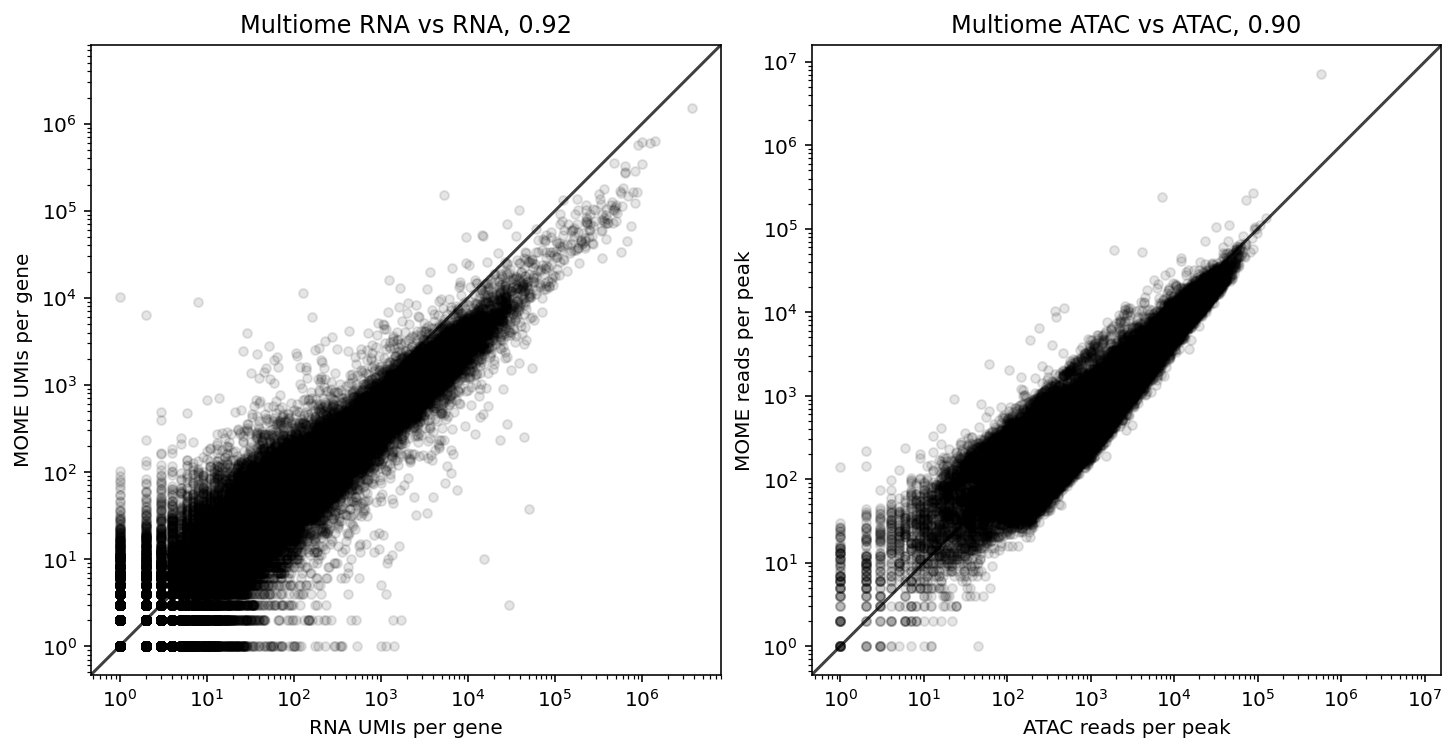

In [12]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2, constrained_layout=True)

ax = axs[0]
x = mg.mod["gene"].var["counts_sum"].values
y = mu.mod["gene"].var["counts_sum"].values

lx, ly = np.log1p(x.reshape(-1,1)), np.log1p(y)
reg = LinearRegression().fit(lx, ly)
r2 = reg.score(lx, ly)

ax.scatter(x, y, alpha=0.1, s=20, color="k")

kwd = {
    "title": f"Multiome RNA vs RNA, {r2:,.2f}",
    "xscale": "log",
    "yscale": "log",
    "xlabel": f"RNA UMIs per gene",
    "ylabel": f"MOME UMIs per gene",
}

ax.set(**kwd)
yex(ax)


ax = axs[1]

x = ma.mod["atac"].var["counts_sum"].values
y = mu.mod["atac"].var["counts_sum"].values
lx, ly = np.log1p(x.reshape(-1,1)), np.log1p(y)
reg = LinearRegression().fit(lx, ly)
r2 = reg.score(lx, ly)

ax.scatter(x, y, alpha=0.1, s=20, color="k")

kwd = {
    "title": f"Multiome ATAC vs ATAC, {r2:,.2f}",
    "xscale": "log",
    "yscale": "log",
    "xlabel": f"ATAC reads per peak",
    "ylabel": f"MOME reads per peak",
}
ax.set(**kwd)
yex(ax)
fig.show()

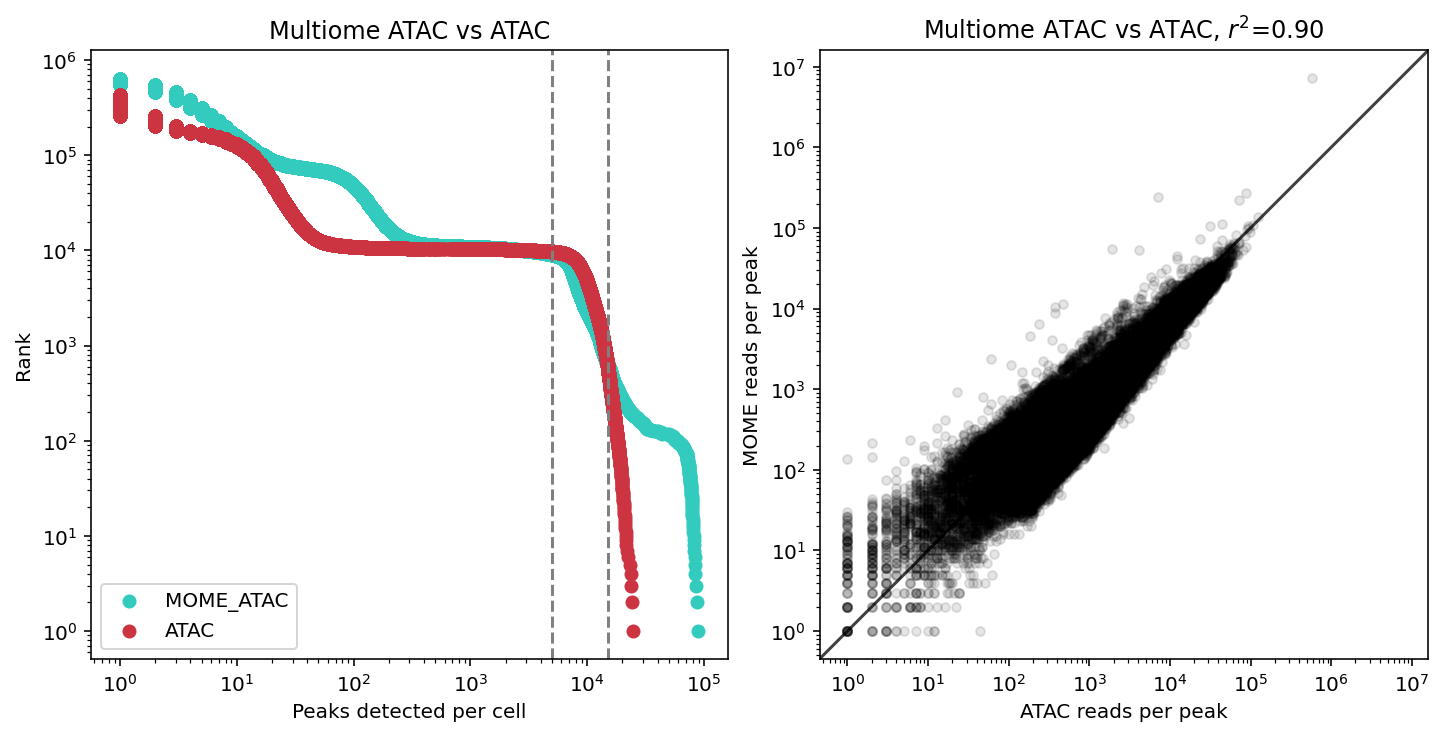

In [13]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2, constrained_layout=True)

# Gene/gene and peak/peak correlation

ax = axs[0]

x = mu.obs["atac:counts_nnzero"].sort_values(ascending=False)
y = np.arange(x.shape[0])
ax.scatter(x,y, label="MOME_ATAC", c=blue)

x = ma.obs["atac:counts_nnzero"].sort_values(ascending=False)
y = np.arange(x.shape[0])
ax.scatter(x,y, label="ATAC", c=red)

ax.set(**{
    "xscale": "log",
    "yscale": "log",
    "xlabel": "Peaks detected per cell",
    "ylabel": "Rank",
    "title": "Multiome ATAC vs ATAC"
})
ax.axvline(atac_lim[0], color="grey", linestyle="--")
ax.axvline(atac_lim[1], color="grey", linestyle="--")
ax.legend()

ax = axs[1]
x = ma.mod["atac"].var["counts_sum"].values
y = mu.mod["atac"].var["counts_sum"].values
lx, ly = np.log1p(x.reshape(-1,1)), np.log1p(y)
reg = LinearRegression().fit(lx, ly)
r2 = reg.score(lx, ly)

ax.scatter(x, y, alpha=0.1, s=20, color="k")

kwd = {
    "title": f"Multiome ATAC vs ATAC, $r^2$={r2:,.2f}",
    "xscale": "log",
    "yscale": "log",
    "xlabel": f"ATAC reads per peak",
    "ylabel": f"MOME reads per peak",
}
ax.set(**kwd)
yex(ax)

fig.savefig("figures/10x_pbmc_mome-x_tradeoffs.png", bbox_inches="tight", dpi=300)
fig.show()

## RNA UMI Collapse ratio

In [14]:
muon.pp.intersect_obs(mu)

In [15]:
print(mu.mod["gene"].shape, mu.mod["atac"].shape, sep="\n")

(581313, 60664)
(581313, 119876)


In [16]:
co = 1e3

In [17]:
mask = (mu.obs["gene:counts_nnzero"] + 
        mu.obs["atac:counts_nnzero"]) > co
good_sum = mu[mask].obs["gene:counts_sum"].sum()

# what fraction of umis come from cells that pass filter?
mg_sum = (good_sum / mu.obs["gene:counts_sum"].sum())

In [18]:
mg_sum

0.84590167

In [19]:
mask = mg.obs["gene:counts_nnzero"] > co
good_sum = mg[mask].obs["gene:counts_sum"].sum()

# what fraction of umis come from cells that pass filter?
gg_sum = (good_sum / mg.obs["gene:counts_sum"].sum())

In [20]:
gg_sum

0.9085636

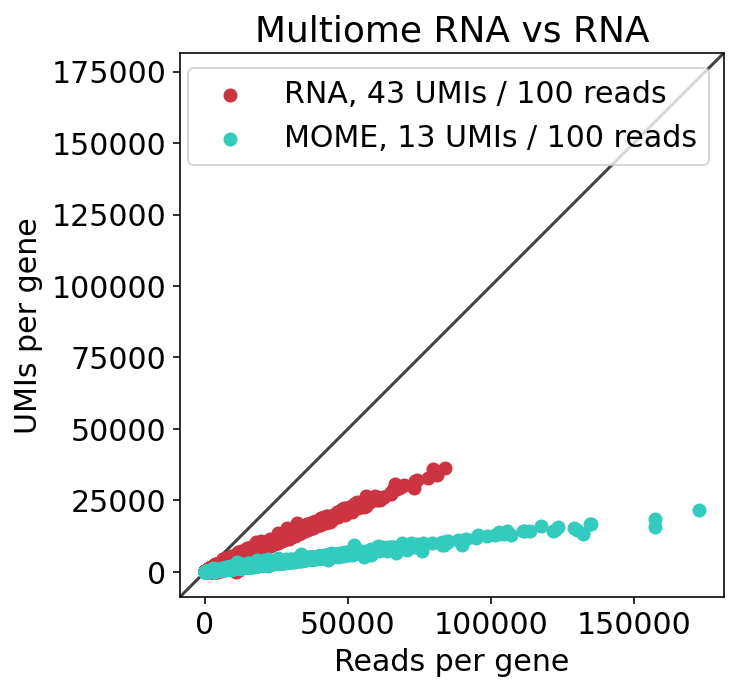

In [33]:
fig, ax = plt.subplots(figsize=(5,5))

x = mg.obs["gene:reads_sum"].values
y = mg.obs["gene:counts_sum"].values*gg_sum


lx, ly = x.reshape(-1,1), y
reg = LinearRegression().fit(lx, ly)
r2 = reg.score(lx, ly)

ax.scatter(x,y, color=red, label=f"RNA, {int(reg.coef_[0]*100):,.0f} UMIs / 100 reads")

x = mu.obs["gene:reads_sum"].values
y = mu.obs["gene:counts_sum"].values*mg_sum


lx, ly = x.reshape(-1,1), y
reg = LinearRegression().fit(lx, ly)
r2 = reg.score(lx, ly)

ax.scatter(x,y, color=blue, label=f"MOME, {int(reg.coef_[0]*100):,.0f} UMIs / 100 reads")


kwd = {
    "title": "Multiome RNA vs RNA",
    "xscale": "linear",
    "yscale": "linear",
    "xlabel": f"Reads per gene",
    "ylabel": f"UMIs per gene",

}
ax.set(**kwd)
ax.legend(loc='upper right')
yex(ax)
fig.savefig("figures/10x_pbmc_mome-reads_umis_cmp.png", bbox_inches="tight", dpi=300)
fig.show()